# <span style="color:#2c061f"> Macro 318: Tutorial #3 </span>  

<br>

## <span style="color:#374045"> Optimisation and the consumer problem </span>


#### <span style="color:#374045"> Lecturer: </span> <span style="color:#d89216"> <br> Dawie van Lill (dvanlill@sun.ac.za) </span>

# Introduction

Before getting started with this tutorial I want to acknowledge the excellent work being done by Jeppe Druedahl and his team at Copenhagen. The following tutorial is basically a port of the Python lecture for his course on numerical methods. Much of the material is directly copied, but there are also some smaller amendments to fit the 318 course. The original lecture can be found [here](https://numeconcopenhagen.netlify.app/lectures/Optimize_print_and_plot).

In [1]:
import Pkg

In [2]:
Pkg.add("DataFrames");
Pkg.add("ForwardDiff")
Pkg.add("IntervalRootFinding")
Pkg.add("Ipopt");
Pkg.add("JuMP"); # Optimisation package
Pkg.add("LaTeXStrings")
Pkg.add("Optim");
Pkg.add("Plots");
Pkg.add("Symbolics")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch

In [3]:
using DataFrames
using ForwardDiff
using IntervalRootFinding
using Ipopt
using JuMP
using LaTeXStrings
using Optim
using Plots
using Symbolics

# Learning objectives

# Unconstrained optimisation

In the previous tutorial we looked at derivatives and conditions under which a maximum or minimum for a function can be achieved. This is essentially a problem in unconstrained optimisation. We will reiterate some of the main points from the previous tutorial, and also continue from where we concluded. When we are done with unconstrained optimisation we will move to the setting of constrained optimisation. This is a very important topic and will form the basis for two crucial examples that we will cover in the span of the following two tutorials. 

Let us restate the optimisation problem from the previous tutorial, as a quick reminder. In the case of unconstrained optimisation we want to optimise (let us stick with minimization for this example) a function on the whole space $X = \mathbb{R}^{n}$. The optimisation problem is then to 

$$
\min_{x \in \mathbb{R}^n} f(x).
$$

The optimal point would be a global minimum, which is a point $x\in X = \mathbb{R}^{n}$ which satisfies, 

$$
f(x) \le f(y) \text{ for all }y\in X.
$$

Note that since $x \in \mathbb{R}^{n}$ it can be seen as an $n$ element vector. 

## Optimisation and gradients?

Remember that the gradient of the function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ is denoted $\nabla f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n} $ and returns a vector of values, 

$$
\nabla f(x) = \left(\frac{\partial f}{\partial x_1}(x),\frac{\partial f}{\partial x_2}(x),\dots,\frac{\partial f}{\partial x_n}(x) \right)
$$

Here we are taking partial derivatives with respect to each of the components in the $x$ vector. 

Consider a differentiable function $f$ over $X=\mathbb{R}^n$. If $x$ is its local minimum, then $\nabla f(x)=0$. In other words, in the case of $n = 2$, both partial derivatives need to be zero. This is a direct analogue of the $n = 1$ case (which is the univariate case). 

Points with $\nabla f(x)=0$ are known as **stationary points**. 

Optimization algorithms often try to find local minima or stationary points, hoping to minimize the function $f$. 

In [ ]:
function minmax()
	
	v = collect(range(-10, stop = 10, length = 30))  # values
	mini = [x^2 + y^2 for x in v, y in v]
	maxi = -mini   # max is just negative min
	saddle = [x^2 + y^3 for x in v, y in v]
	
	return Dict(:x => v,:min => mini, :max => maxi, :saddle => saddle)
end;

In [ ]:
function mmplotter(s::Symbol)
	
    d = minmax()

    surface(d[:x], d[:x], d[s], fillalpha = 0.7, legend = false, fillcolor =:viridis)
end;

In [ ]:
mmplotter(:min)

In the figure above we have an example of a function, $f(x, y) = x^2 + y^2$, that has a local minimum. We can determine where the stationary point is by setting the gradient equal to zero. If we want to know whether this is in fact a minimum we need to perform a second partial derivative test. For this test we need to calculate the Hessian matrix of the function. This is a $2 \times 2$ matrix of partial derivatives of $f$ whose determinant is given by $d = f_{xx}f_{yy} - f_{xy}^2$.

The function has a local minimum if $f_{xx} < 0$ and $d > 0$. The second derivative test is similar to the one we employed in the univariate case, without considering the determinant of the Hessian matrix. 

What does mean for us? It means that we need to compute two quantities in order to determine if our function has a local minimum. Let us consider an example to see how this works. 

### Example: Profit maximisation

Suppose that we have the following profit function, 

$$
\Pi = -5 + 30x - 3x^2 + 25y - 5y^2 +xy
$$

At what level of output will profit be maximized? 

We can start by plotting the function to get an idea of what it looks like. 

In [4]:
function profit_function()
	
	v = collect(range(0, stop = 8, length = 30))  # values
	profit = [-5 + 30x - 3x^2 + 25y - 5y^2 + x*y for x in v, y in v]
	
	return Dict(:x => v, :profit => profit)
end;


In [5]:
function profit_plotter(s::Symbol)
	
    d = profit_function()

    surface(d[:x], d[:x], d[s], fillalpha = 0.7, legend = false, fillcolor =:viridis)
end;

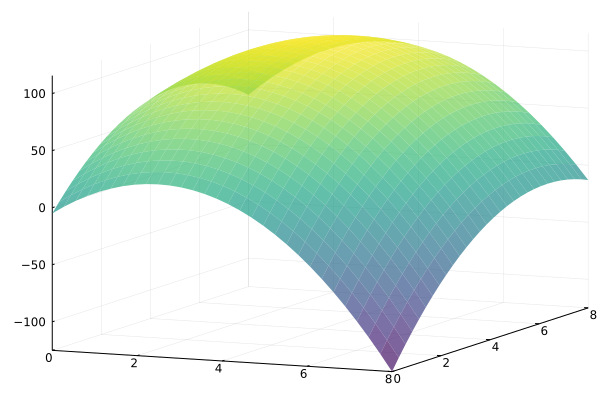

In [6]:
profit_plotter(:profit)

The function seems like it will have a maximum. We first need to look at the gradient and then check the second order conditions to determine if this is true. In order to determine the gradient we need the partial derivatives with respect to $x$ and $y$. 

### Exercise

Conduct the following steps to determine if we have a local maximum. 

1. Calculate the partial derivatives with respect to $x$ and $y$ of the profit function. 
2. Calculate $f_{xx}$
3. Calculate $d = f_{xx}f_{yy} - f_{xy}^2$

If $f_{xx} < 0$ and $d > 0$, then we have a local maximum. We will be calculating these quantities with Julia to determine if there is a maximum and also where the maximum is located. 

### Local optima via Julia (optional)

In most cases we will not be calculating the Hessian and it's determinant by hand. We would rather use the computer to do these complicated things for us. Let us look at the example that we solved by hand above and try and solve the same problem, but this time with our software package. We will use the `ForwardDiff` package here. 

In [7]:
x = rand(2)

Π(x) = -5 + 30 * x[1] - 3 * x[1] ^ 2 + 25 * x[2] - 5 * x[2] ^ 2 + x[1] * x[2] 

∇Π(x) = ForwardDiff.gradient(Π, x) # gradient

H(x) = ForwardDiff.hessian(Π, x) # Hessian

H (generic function with 1 method)

In [8]:
∇Π(x) # both partial derivatives are positive

2-element Vector{Float64}:
 30.145568821739243
 17.96391743300419

In [9]:
H(x) 

2×2 Matrix{Float64}:
 -6.0    1.0
  1.0  -10.0

From this we see that both partial derivatives are positive. The value for $f_{xx} = -6 < 0$ and the value for $d = f_{xx}f_{yy} - f_{xy}^2 = (-6)*(-10) - (1.0)^2 = 59 > 0$. This means that we have a maximum. Next we are going to try and figure out where the gradient is equal to zero. We will use the `IntervalRootFinding` package for this. 

In [10]:
f( (x, y) ) = -5 + 30 * x - 3 * x ^ 2 + 25 * y - 5 * y ^ 2 + x * y
∇f = ∇(f)
rts = roots(∇f, IntervalBox(-5..6, 2), IntervalRootFinding.Newton, 1e-5)

1-element Vector{Root{IntervalBox{2, Float64}}}:
 Root([5.50847, 5.50848] × [3.05084, 3.05085], :unique)

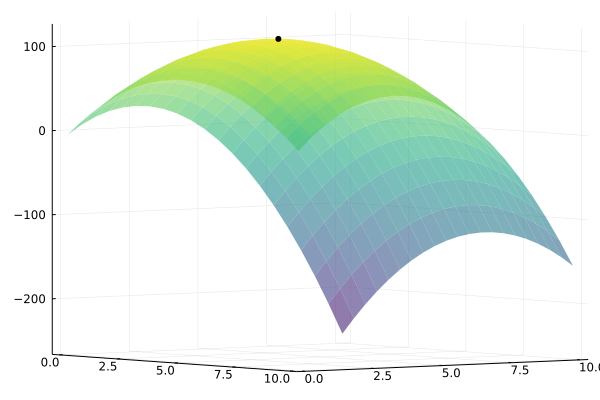

In [11]:
midpoints = mid.(interval.(rts))

xs = first.(midpoints)
ys = last.(midpoints)

surface(0:0.5:10, 0:0.5:10, (x,y) -> f([x, y]), fillalpha = 0.6, legend = false, fillcolor =:viridis, camera = (50, 10))
scatter!(xs, ys, f.(midpoints), color = :black)

In the graph you can see that the scatter point is the maximum. 

As an aside, it is possible to have a function that has neither a local maximum or minimum. This is called a saddle point. The following figure has a saddle point. 

In [ ]:
mmplotter(:saddle)

## `Optim` for optimisation

We can use the excellent `Optim` package to find the answer to unconstrained optimisation problems, both univariate and multivariate optimisation. In the univariate case we could optimise a function like our quadratic utility function from the previous tutorial, 

$$
U(x) = x - α x ^ 2
$$

The optimisation routine in this case is called [Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method). If you are interested in numerical optimisation this is worthwhile taking a look at.  

In [ ]:
α = 0.2
result = maximize(x -> x - α * x ^ 2, -10, 10) # x -> x - α * x ^ 2 is the same as U(x) = x - α * x ^ 2. It is called an anonymous function representation. 

In [ ]:
maximum(result)

This gives the same answer as in Tutorial 2! 

This was super easy right!?!

I think it is much easier than working out derivatives and setting them to zero and checking all those conditions. What I want you to take away from this is that if you can use an optimisation routine to try and solve a problem, use it! There are going to be instances where it isn't as easy as simply using a solver, but most of the time this is going to be your best case scenario. Don't reinvent the wheel!

Now let's move on to the multivariate case. Univariate is always the simplest, so perhaps multivariate is going to give us a few headaches?

Let us consider the profit maximization problem from the previous section. Remember that we want to maximize profit, where profit is given by, 

$$
\Pi = -5 + 30x - 3x^2 + 25y - 5y^2 +xy
$$

Now let us try and code up an answer to this problem, 

In [ ]:
Π(x) = -5 + 30 * x[1] - 3 * x[1] ^ 2 + 25 * x[2] - 5 * x[2] ^ 2 + x[1] * x[2] 
results = maximize(Π, [0.0, 0.0], LBFGS(), autodiff = :forward)

You might notice the `L-BFGS` algorithm is used here. In addition, we used forward mode auto differentiation. The reason is that the `L-BFGS` algorithm requires derivatives to operate. If we don't specify the auto differentiation method then the algorithm will use finite differences, which is less accurate than auto differentiation. We could have also supplied analytical derivatives here, the ones that we worked out by hand earlier. This would have worked equally well. In this case, the code would have looked like this, 

In [ ]:
# Provide analytical partial derivatives

function g!(G, x)
    G[1] = 30.0 - 6.0 * x[1] + x[2] 
    G[2] = 25.0 - 10.0 * x[2] + x[1]
end

results_1 = maximize(Π, g!, [0.0, 0.0], LBFGS()) # use analytical derivatives

We see that the result is basically the same across these methods. 

# Constrained optimisation

In this section we talk about the possibility of adding a constraint to the unconstrained problem from before. These can be either equality or inequality constraints. The normal formulation of a constrained optimisation problem is,

$$
\begin{align*}
\min_{x \in \mathbb{R}^n}\qquad &f(x) \\
\text{subject to}\qquad &g_i(x) \le 0,\ i=1,\dots,I, \\
&h_j(x) = 0,\ j=1,\dots,J.
\end{align*}
$$
where functions $g_i$ generate **inequality** constraints, while functions $h_j$ generate **equality** constraints. 

**Important point**: We can potentially have equality and inequality constraints in our constrained optimisation problem. 

Some times the constrained solution is going to coincide with the unconstrained solution. This will be the case when the constraint is not binding. We will showcase this with an example soon. 

We start with an example where we have a **single equality constraint**.

How would we go about solving this problem by hand, and how would we do this via Julia?

## Equality constraint: Profit maximization revisited

In the following example we will optimize a function subject to a single equality constraint, 

$$
\begin{align*}
\min_{x \in \mathbb{R}^n}\qquad &f(x) \\
&h(x) = 0
\end{align*}
$$

We are looking for the contour lines of the function $f(x)$ that are aligned with the contours of $h(x) = 0$. 

This means that we want to find the optimal value for $x$ such that $h(x) = 0$.

In terms of gradients we are going to be looking for the point where $\nabla f(x) = \lambda \nabla h(x)$.

The scalar value $\lambda$ is known as the **Lagrange multiplier**.

We can reformulate our constrained optimisation problem in the form of a Lagrangian as follows, 

$$
\mathcal{L}(x,\lambda) = f(x) - \lambda h(x)
$$

where $\mathcal{L}$ means Lagrangian. 

Let us consider our profit maximization example from before but this time with a constraint, so that we can get more comfortable with the idea of a Lagrangian,

$$
\begin{align*}
\min_x \qquad & -5 + 30x_1 - 3x_1^2 + 25x_2 - 5x_2 \\
\text{subject to } \qquad & x_1 - x_2 = 0
\end{align*}
$$

From this formulation we can form the Lagrangian, 

$$
\mathcal{L}(x_1,x_2,\lambda) = \left(-5 + 30x_1 - 3x_1^2 + 25x_2 - 5x_2^2 \right) - \lambda(x_1 - x_2)
$$

In order to solve the problem we have to compute the gradient with respect to $x_1$, $x_2$, $\lambda$ and set to zero. Then we need to solve that system of equations. We will quickly do this problem by hand, but in the future we will let the computer do all of the hard work. 

## Lagrangian 'by hand'

We have to get the first order conditions, which means that we have to calculate partial derivatives with respect to $x_1$, $x_2$, $\lambda$. 

I am going to cheat a bit here and calculate the partial derivatives with the `Symbolics` package.  

In [ ]:
Symbolics.@variables x1 x2 λ

g = -5 + 30 * x1 - 3 * x1 ^ 2 + 25 * x2 - 5 * x2 ^ 2 - λ * (x1 - x2)

H = Differential(x1);
I = Differential(x2);
J = Differential(λ);

expand_derivatives(H(g)) # partial derivative of f wrt to x1

In [ ]:
expand_derivatives(I(g)) # partial derivative of f wrt to x2

In [ ]:
expand_derivatives(J(g)) # partial derivative of f wrt to λ

This means that we have following partial derivatives, 

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial x_1} & \rightarrow 30 + x_2 - 6x_1 -\lambda = 0 \\
\frac{\partial \mathcal{L}}{\partial x_2} & \rightarrow 25 + x_1 + \lambda - 10x_2  = 0 \\
\frac{\partial \mathcal{L}}{\partial \lambda} & \rightarrow -x_1 + x_2 = 0 
\end{align*}
$$

Now we have three equations and three unknowns, which means that we could solve for $x_1$, $x_2$ and $\lambda$. We see that this is a system of linear equations, which means that we can actually use the computer to solve the problem for us. How can we do this? Well this system can be written in matrix format. Once it is in matrix format, we can easily solve it via the backslash `\` operator in Julia. 

To write the system in terms of a matrix we will need to reorder our equations, 

$$
\begin{align*}
- 6x_1 + x_2 -\lambda & = -30 \\
x_1 - 10x_2 + \lambda & = -25 \\
-x_1 + x_2 & = 0 
\end{align*}
$$

Now we can write it in matrix form, 

$$
\begin{bmatrix}
-6 & 1 & -1 \\
1 & -10 & 1 \\
-1 & 1 & 0 
\end{bmatrix}

\cdot

\begin{bmatrix}
x_1 \\
x_2 \\
\lambda 
\end{bmatrix}

= 

\begin{bmatrix}
-30 \\
-25 \\
0
\end{bmatrix}
$$

This can be written in compact mathematical form as $Ax = b$. We then need to solve for $x = A^{-1}b$. We can solve this with Julia as follows, 



In [ ]:
A = [-6 1 -1; 1 -10 1; -1 1 0]
b = [-30; -25; 0]

x_ans = A \ b

The solution here shows that the optimal point will be where $x_1 = 3.93, x_2 = 3.93$.

In [ ]:
f(x1, x2) = -5 .+ 30 .* x1 .- 3 .* x1 .^ 2 .+ 25 .* x2 .- 5 .* x2 .^ 2 .+ x1 .* x2 # objective function
c(z) = z # constraint
x = -5:0.05:10	

p1 = surface(x, x, (x, y) -> f(x, y), xlab = L"x_1", ylab = L"x_2", legend = false, alpha = 0.9)

scatter3d!(p1, [x_ans[1]], [x_ans[2]], [f(x_ans[1], x_ans[2])], markercolor = :red)

p2 = contour(x, x, (x,y) -> f(x, y), lw = 1.5, xlab = L"x_1", ylab = L"x_2", legend = false)
plot!(p2, c, -5, 10, label = "", lw = 2, color = :black)
scatter!(p2, [x_ans[1]], [x_ans[2]], markersize = 5, markercolor = :red)

plot(p1, p2, size = (1000, 400))

## Inequality constraint: Consumer problem

We have worked with a problem where there was an equality constraint, now we are going to introduce the idea of an inequality constraint. This section will be a bit more tricky, since we are going to employ several methods to solve the problem. I will indicate which methods are worthwhile spending a lot of time on and which you can just simply browse through. The code here will become a bit more complex, but I will try and explain everything as clearly as possible.  

Consider the following consumer problem. You should be quite familiar with this, since it is very similar to the one that we covered in chapter 4 of Williamson last year. 

We have an economy with two goods and the following components, 

* utility function $u(x_1,x_2):\mathbb{R}^2_{+}\rightarrow\mathbb{R}$,
* exogenous income $I$, and 
* price-vector $(p_1,p_2)$,

In the textbook, from Chapter 4, the inputs into the utility function are consumption and leisure. You might recognise the problem the components $x_1 = C_1$ and $x_2 = l_1$. These two goods form part of a consumption bundle. The problem that we are posing in this notebook is more general, but also applicable to the textbook chapters. 

We can write this problem as follows, 


$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1},x_{2}}u(x_{1},x_{2})\\
 \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq I,\,\,\,p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

Since this is quite a simple problem, we can solve it by hand. The requires that we setup a Lagrangian and then work out the first order conditions. 

## Lagrangian 'by hand'

For this problem we need to specify the explicit functional form of the utility function. If we had, for example, a Cobb-Douglas utility function, such as, 

$$
u(x_1,x_2) = x_1^{\alpha}x_2^{1-\alpha}
$$

then we can pose the Lagrangian as follows, 

$$
\mathcal{L}(x_1,x_2,\mu) = \left(x_1^{\alpha}x_2^{1-\alpha} \right) - \mu(p_1x_1 - p_2x_2 - I)
$$

This means that we have following partial derivatives, 

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial x_1} & \rightarrow \alpha x_1^{\alpha - 1}x_2^{1-\alpha} - \mu p_1 = 0 \\
\frac{\partial \mathcal{L}}{\partial x_2} & \rightarrow (1 - \alpha) x_2^{-\alpha}x_1^{\alpha} + \mu p_2 = 0 \\
\frac{\partial \mathcal{L}}{\partial \lambda} & \rightarrow - p_1x_1 + p_2x_2 + I = 0
\end{align*}
$$

We can rearrange the last equation and then we have $x_1  = \frac{p_2x_2}{p_1} + \frac{I}{p_1}$. We can also set the first and second equation equal to each other since they both share the term $\mu$.  

$$
\begin{align*}
\frac{\alpha x_1^{\alpha - 1}x_2^{1-\alpha}}{p_1} & =  - \frac{(1 - \alpha) x_2^{-\alpha}x_1^{\alpha}}{p_2} \\
\frac{\alpha x_2}{x_1p_1} & =  - \frac{(1 - \alpha)}{p_2} \\
x_2 & =  - \frac{(1 - \alpha)x_1p_1}{\alpha p_2} \\
\end{align*}
$$

Substitute this into our equation for $x_1$ and then we have, 

$$
\begin{align*}
& x_1  = -\frac{p_2\frac{(1 - \alpha)x_1p_1}{\alpha p_2}}{p_1} + \frac{I}{p_1} \\
& x_1  = -\frac{\frac{(1 - \alpha)x_1p_1}{\alpha}}{p_1} + \frac{I}{p_1} \\ 
& x_1  = -\frac{(1 - \alpha)x_1}{\alpha} + \frac{I}{p_1} \\
& x_1 + \frac{x_1 - \alpha x_1}{\alpha}  =  \frac{I}{p_1} \\
& x_1 + \frac{x_1}{\alpha} - x_1  =  \frac{I}{p_1} \\
& x_1^{*} = \alpha\frac{I}{p_1}
\end{align*}
$$

Now we finish off by substituting $x_1^{*}$ into $x_2$, 

$$
\begin{align*}
x_2^{*} & =  - \frac{(1 - \alpha)\alpha\frac{I p_1}{p_1}}{\alpha p_2} \\
 & =  - (1 - \alpha)\frac{I}{p_2}
\end{align*}
$$

The solution is then provided algebraically as, 

$$
\begin{aligned}
x_1^{\ast} &= \alpha \frac{I}{p_1} \\
x_2^{\ast} &= -(1 - \alpha) \frac{I}{p_2}
\end{aligned}
$$

which implies that $\alpha$ is the budget share of the first good and $1-\alpha$ is the budget share of the second good. 

While this is not a difficult problem to solve by hand, it would be way more convenient to be able to do this on a computer. One of the main reasons is that if the utility function changes we don't need to do the whole process again, we simply need to alter the utility function in our code and we can calculate the new solution. 

## Utility function

We have worked with the quadratic utility function before. However, that is function is not frequently used. Let us write down the utility function above in terms of code. Remember how to construct functions from the first lecture? If not, please consult the section on functions. 

In [ ]:
function u_func(x1, x2, α = 0.5)
    return x1 .^ α .* x2 .^ (1 .- α)
end;

We can evaluate this utility function for different values of the inputs $x_1$ and $x_2$.

In [ ]:
x1 = 1
x2 = 3

u = u_func(x1, x2)

println("x1 = $x1, x2 = $x2 -> u = $u")

We can also loop through multiple values for $x_1$ to see how the values for the utility function changes. This reflects the elasticity of utility with respect to $x_1$

In [ ]:
x1_values = [2, 4, 6, 8, 10, 12, 14, 16]
x2 = 3

for x1 in x1_values
    u = u_func(x1, x2)

    println("x1 = $x1, x2 = $x2 -> u = $u")
end

For a little nicer output we can use the `enumerate` command, 

In [ ]:
for (i, x1) in enumerate(x1_values)
    u = u_func(x1, x2)

    println("$i: x1 = $x1, x2 = $x2 -> u = $u")
end

We can now see how utility changes with different values for $x_1$. In this case it seems that there is an increase in utility associated with an increase in $x_1$. 

In mathematical terms, it seems that the utility function is monotonically increasing with respect to changes in $x_1$. The way that we would determine the change in the utility function with respect to $x_1$ over the entire function is by using the tools of calculus. 

## Plotting the utility function

The next thing we might want to do in our analysis is to plot the utility function. We want some idea of what the function looks like graphically. We could draw it by hand, but it is much easier to utilise the computer. 

First, we are going to replicate the indifference curve similar to Figure 4.1 in the textbook. 

In [ ]:
function indifference_plot()

    x = 0:0.01:5 # Define the range of possible values for x1 and x2. 
    b = [1, 2]

    plot(x, x, (x, y) -> u_func(x, y), st = :contour, colour = :ice, levels = b, legend = false, lw = 2)
    
end;

In [ ]:
p_ind = indifference_plot()

Here we have two indifference curves for the consumer. Each indifference curve represents a set of consumption bundles among which the consumer is indifferent. Higher indifference curves represent higher welfare for the consumer. 

In our textbook we calculated the marginal rate of substitution between goods $x_1$ and $x_2$ at different points along the indifference curves. It was defined to be the negative of the slope of the indifference curve passing through a certain point. 

#### Exercise

Now as an exercise, try and take the partial derivative of $u$ with respect to $x_1$. What do you get? 

The answer should be: $\alpha(x_1)^{\alpha - 1}(x_2)^{1-\alpha}$

Can you see how we got to this answer? We will talk about this in class. 

There are different packages in Julia that we can use to calculate partial derivatives, so that we don't need to do these things by hand!

In [ ]:
x = [3.8, 1.2]
plot(p_ind, x)

## Utility plot

In order to plot a three dimensional version of the utility function

A much simpler way to construct our grids is to simply use the internal functions that Julia has for constructing grids. The reason for the previous exercise was to get you more comfortable thinking through loops and conditional statements 

We can create equally spaced grids for $x_1$ and $x_2$ in several ways. The easiest is the following, 

In [ ]:
x1_values_easy = collect(0:0.01:10); # 1001 element vector
x2_values_easy = collect(0:0.01:10);

An alternative would be to use the `LinRange` function in Julia. 

In [12]:
x1_values_lr = LinRange(0, 10, 1000); # 1000 element vector

Using these values we can plot the utility function as before, but this time we will use a different approach, which doesn't require us to write out a whole loop for the utility function as before, 

In [ ]:
plot_2 = plot(x1_values_easy, x2_values_easy, (x1_values_easy, x2_values_easy) -> u_func(x1_values_easy, x2_values_easy), st = :surface, xlabel = "x1", ylabel = "x2", zlabel = "utility", camera = (30, 60), colour = :ice, legend = false)

We have the graph for the utility function, now we need to think about finding a solution to our **constrained optimisation** problem. We want to achieve the highest level of utility, given the constraint that we are provided. 

# Optimisation with Julia

In this next section we talk about three ways (algorithms) for finding a solution to our original optimisation problem. Once again, remember that the problem that we want to solve is the following, 

$$
\begin{aligned}
V(p_{1},p_{2},I) & = \max_{x_{1},x_{2}}u(x_{1},x_{2})\\
 & \text{s.t.}\\
p_{1}x_{1}+p_{2}x_{2} & \leq I,\,\,\,p_{1},p_{2},I>0\\
x_{1},x_{2} & \geq 0
\end{aligned}
$$

### Budget and preferences

We now have a solution to our constrained optimisation problem. We have already plotted the utility function, so let us now plot the utility function with our budget constraint and the optimal point. Remember, the budget constraint is given by, 

$$
p_{1}x_{1}+p_{2}x_{2} \leq I,\,\,\,p_{1},p_{2},I>0,\,\, x_{1},x_{2}  \geq 0
$$

We can combine the budget and utility together in a contour plot. For this problem we are going to assume that $p1 = 1$, $p2 = 2$ and that $I = 10$.

In [ ]:
p1 = 1;
p2 = 2;
I = 10;

In [ ]:
x = 0:0.01:10

b = collect(0:0.5:10);
c(z) = 10 - 2 .* z;

plot_3 = plot(x, x, (x, y) -> u_func(x, y), st = :contour, colour = :ice, levels = b, legend = false);

plot!(plot_3, c, 0.01, 10, ylims = (0,10), lw = 1.5, color = :black, fill=(0,0.5,:blue))
scatter!(plot_3, [3.75], [2.5], markersize = 5, markercolor = :red) # This includes the solution, but we haven't calculated this answer yet. 


## Algorithm 1: Using a Solver (Optim)

The best option is to try and use code that someone else has written. 

Sometimes it is useful to write your own routines if no other option is available. However, if you can make use of a package from a professional software developer that is the first prize. 

Do not try and reinvent the wheel. Some of you might end of being software engineers, and then you can spend countless hours trying to write performant code. However, most of you are going to use code for a specific goal.

My ideal world is one where everyone knows something about software engineering and we students are aware of best programming practices. However, I am aware not everyone is interested in these topics. 

In this section we will be making use of `Optim.jl`. This package does not allow constrained optimisation, so we are going to have to be a bit creative with respect to the construction of constraints for the problem. 

We will be working with a package that deals directly with constrained optimisation for problems with nonlinear objective functions in the next section, but it is worthwhile seeing what `Optim.jl` can do in the meantime. 



We will be wrapping our code block in a function. This is generally good practice. We want to operate by writing functions whenever possible. 

In [ ]:
function value_of_choice(x)

    α = 0.25
    I = 10
    p1 = 1
    p2 = 2

    x1 = x[1]
    x2 = x[2]

    penalty = 0

    exp = p1 * x1 + p2 * x2 # total expenses

    if exp > I # expenses > income is not allowed
        fac = I/exp
        penalty = penalty + 1000 * (exp - I) # calculate the penalty
        x1 = x1 * fac
        x2 = x2 * fac
    end

    return -u_func(x1, x2, α) + penalty
end

In [ ]:
I = 10
p1 = 1
p2 = 2

initial_x = [I/p1/2, I/p2/2]

res = optimize(value_of_choice, initial_x)

In [ ]:
Optim.minimizer(res) 

## Algorithm 2: Using a Solver (JuMP)

In the next section we will use a really cool package called `JuMP.jl` to solve the model.

In [ ]:
model = Model(Ipopt.Optimizer)
@variable(model, x1 >= 0)
@variable(model, x2 >= 0)
@NLobjective(model, Max, x1 ^ 0.25 * x2 ^ 0.75)
@NLconstraint(model, x1 + 2x2 <= 10)
print(model)

In [ ]:
optimize!(model)

In [ ]:
@show value(x1)

In [ ]:
@show value(x2)

If we compare these values to our solution from before we will see that they are quite similar. 